In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
x_train = pd.read_table('x_train.csv', index_col=0, header=0, sep=',').values
x_test = pd.read_table('x_test.csv', index_col=0, header=0, sep=',')

/Users/Leslie/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,47,53) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
data = pd.read_table('properties_2016.csv', header=0, index_col=None, sep=',')
train = pd.read_table('train_2016.csv', sep=',')
df_train = train.merge(data, how='left', on='parcelid')
y_train = df_train['logerror']

/Users/Leslie/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [14]:
# from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

## Benchmark Plot

In [15]:
def benchmark_plot():
    result_benchmark = pd.read_csv('results/result_0.0646523.csv')['201610']
    plt.close()
    plt.plot(range(len(result_benchmark)), 
             result_benchmark, 
             '.', color='m', alpha=0.3)
    plt.title('Benchmark Plot')
    plt.show()


scorer_mae = make_scorer(mean_absolute_error, greater_is_better=False)
def hyperopt_train_test(params):
    t = params['type']
    del params['type']
    if t == 'xgb':
        reg = xgb.XGBRegressor(**params)
    else:
        return 0, 0
    cv_score = cross_val_score(reg, x_train, y_train, scoring=scorer_mae, cv=5)
    score_mean = cv_score.mean()
    score_std = cv_score.std()
    return score_mean, score_std

space = hp.choice('classifier_type', [
    {
        'type': 'xgb',
        'learning_rate': hp.uniform('learning_rate', 0.02, 0.1),
        'min_child_weight': hp.choice('min_child_weight', range(30, 60)),
        'max_depth': hp.choice('max_depth', range(5, 10)),
        'subsample': hp.uniform('subsample', 0.2, 0.4),
        'n_estimators': hp.choice('n_estimators', range(150, 200)),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.4, 0.6),
        'reg_lambda': hp.uniform('reg_lambda', 1, 2),
        'reg_alpha': hp.uniform('reg_alpha', 1, 2)
}])

def f(params):
    global best, count
    count += 1
    result = hyperopt_train_test(params.copy())
    acc = result[0]
    std = result[1]
    print('iters:', count, ', acc:', acc, 'std:', std, '\nusing', params, '\n')
    return {'loss': -acc, 'status': STATUS_OK}

count = 0 
trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=50, trials=trials)

## XGBoost

In [232]:
scorer_mae = make_scorer(mean_absolute_error)
import xgboost as xgb

In [233]:
for lr in np.linspace(0.06,0.064,5):
    reg = xgb.XGBRegressor(learning_rate=lr, n_estimators=100, max_depth=4, nthread=4, seed=1234)
    cv_score = cross_val_score(reg, x_train, y_train, scoring=scorer_mae, cv=3)
    score_mean = cv_score.mean()
    score_std = cv_score.std()
    if score_mean < 0.0696:
        print('learning_rate:{0}, Mean:{1:.8f}, STD:{2:.8f}'.format(lr, score_mean, score_std))

learning_rate:0.06, Mean:0.06944411, STD:0.00294492
learning_rate:0.061, Mean:0.06935982, STD:0.00306369
learning_rate:0.062, Mean:0.06942729, STD:0.00298721
learning_rate:0.063, Mean:0.06941760, STD:0.00297759
learning_rate:0.064, Mean:0.06949333, STD:0.00297354


In [157]:
# Score: 0.06943554
params = {'n_estimators': 100, 
          'learning_rate': 0.064, 
          'max_depth': 4,
          'nthread': 4,
          'gamma': 0.0001,
          'seed': 1234}
reg = xgb.XGBRegressor()
reg.set_params(**params)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.0001, learning_rate=0.064, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=1)

In [158]:
reg.fit(x_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.0001, learning_rate=0.064, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=100, nthread=4,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1234, silent=True, subsample=1)

In [159]:
sample = pd.read_csv('sample_submission.csv')
sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(prop, on='parcelid', how='left')

x_test = df_test[train_columns]

for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)
# x_test = x_test.values.astype(np.float32, copy=False)

/Users/Leslie/anaconda3/lib/python3.5/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [160]:
p_test = reg.predict(x_test)

In [161]:
# p_test = 0.97*p_test + 0.03*0.011
sub = pd.read_csv('sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = p_test

sub.to_csv('result_xgb.csv', index=False, float_format='%.8f')

## Random Forest

In [162]:
from sklearn.ensemble import RandomForestRegressor
scorer_mae = make_scorer(mean_absolute_error)

In [188]:
x = pd.concat([x_train, x_test])

In [189]:
x = x.replace(np.inf, 0)

for var in x.columns[x_train.dtypes == 'object']:
    x[var] = x[var].fillna(x[var].mode())
    
for var in x.columns[x.dtypes != 'object']:
    x[var] = x[var].fillna(x[var].dropna().mean())

In [207]:
x_train = x[:90811]
x_test = x[90811:]

In [206]:
# n_estimators=300  --> 0.06925492
for est in [250,300,350]:
    reg = RandomForestRegressor(n_estimators=est, max_depth= 10)
    cv_score = cross_val_score(reg, x_train, y_train, scoring=scorer_mae, cv=3)
    score_mean = cv_score.mean()
    score_std = cv_score.std()
#     if score_mean < 0.0696:
    print('n_estimators:{0}, Mean:{1:.8f}, STD:{2:.8f}'.format(est, score_mean, score_std))

n_estimators:250, Mean:0.06961142, STD:0.00302220
n_estimators:300, Mean:0.06960884, STD:0.00299001
n_estimators:350, Mean:0.06961899, STD:0.00299126


In [208]:
# Score: 0.06960884
params = {'max_depth': 10,
          'n_estimators': 300}

In [209]:
reg = RandomForestRegressor()
reg.set_params(**params)
reg.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [210]:
y_pred = reg.predict(x_test)

In [211]:
sub = pd.read_csv('sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = y_pred

sub.to_csv('result_rf.csv', index=False, float_format='%.8f')

## LightGBM

In [36]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [37]:
xtrain, xvalid, ytrain, yvalid = train_test_split(x_train, y_train, 
                                                  test_size=0.3,
                                                  random_state=1234)

d_train = lgb.Dataset(xtrain, label=ytrain)
d_valid = lgb.Dataset(xvalid, label=yvalid)

In [79]:
params = {}
params['max_bin'] = 20
params['learning_rate'] = 0.00169889 
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = 'l1'          # or 'mae'
params['feature_fraction'] = 0.6
params['feature_fraction_seed'] = 1234
params['sub_feature'] = 0.6      # feature_fraction 
params['bagging_freq'] = 50
params['bagging_seed'] = 1234
params['num_leaves'] = 2**5      
params['min_data'] = 400         # min_data_in_leaf
params['min_hessian'] = 0.05 

# Score:0.06862537
# learning_rate: 0.00169889
# num_leaves:45
# feature_fraction:0.6
# sub_feature:0.6
# bagging_freq:50
# min_data:400

In [81]:
# num_leaves:45, Score:0.06866008
watchlist = [d_valid]
for nl in [2**5 ]:
    params['num_leaves'] = nl
    clf = lgb.train(params, d_train, 1500, watchlist, verbose_eval=False)
    yvalid_pred = clf.predict(xvalid)
    mae = mean_absolute_error(y_pred=yvalid_pred, y_true=yvalid)
    if mae < 0.07:
        print('num_leaves:{0}, Score:{1:.8f}'.format(nl, mae))


num_leaves:32, Score:0.06879412


In [68]:
watchlist = [d_valid]
clf = lgb.train(params, d_train, 500, watchlist, verbose_eval=False)

In [69]:
for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)

In [70]:
clf.reset_parameter({"num_threads":2})
p_test = clf.predict(x_test)

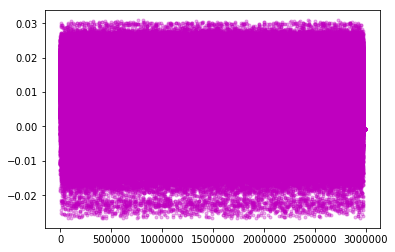

In [255]:
plt.close()
plt.plot(range(len(p_test)), p_test, '.', color='m', alpha=0.3)
plt.show()

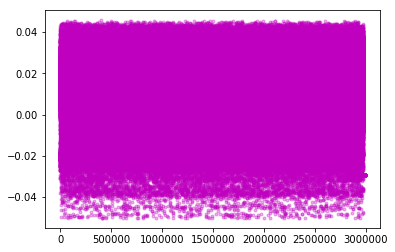

In [71]:
plt.close()
plt.plot(range(len(p_test)), p_test, '.', color='m', alpha=0.3)
plt.show()

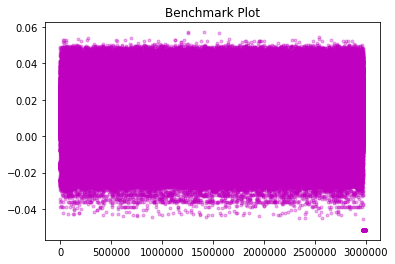

In [75]:
benchmark_plot()

In [76]:
p_test.mean()

0.011931664253981783

In [77]:
# p_test = 0.97*p_test + 0.03*0.01

sub = pd.read_csv('sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = p_test

sub.to_csv('result_without_outliers.csv', index=False, float_format='%.8f')

## Neural Network


In [5]:
from sklearn.grid_search import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras import losses
from keras.wrappers.scikit_learn import KerasRegressor

/Users/Leslie/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/Leslie/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
Using TensorFlow backend.


In [50]:
def create_model(optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(100, input_dim=62, activation='relu'))
    model.add(Dense(25, activation='relu'))
    model.add(Dense(15, activation='relu'))
    model.add(Dense(1, activation='relu'))
    # Compile model
    model.compile(loss='mean_squared_error', 
                  optimizer='rmsprop', 
                  metrics=['mae'])
    return model

In [52]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
x_standard = scaler.fit_transform(x_train)
# nn = KerasRegressor(build_fn=create_model, verbose=0)
nn = create_model()
nn.fit(x_standard[:20000], y_train[:20000],
       nb_epoch=200, batch_size=100)
y_pred = nn.predict(x_standard[-100:])
print(mean_absolute_error(y_train[-100:],
                          y_pred))


/Users/Leslie/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/Leslie/anaconda3/lib/python3.5/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/200
20000/20000 [==============================] - 0s - loss: 0.0341 - mean_absolute_error: 0.0748     
Epoch 2/200
20000/20000 [==============================] - 0s - loss: 0.0341 - mean_absolute_error: 0.0748     
Epoch 3/200
20000/20000 [==============================] - 0s - loss: 0.0341 - mean_absolute_error: 0.0748     
Epoch 4/200
20000/20000 [==============================] - 0s - loss: 0.0341 - mean_absolute_error: 0.0748     
Epoch 5/200
20000/20000 [==============================] - 0s - loss: 0.0341 - mean_absolute_error: 0.0748     
Epoch 6/200
20000/20000 [==============================] - 0s - loss: 0.0341 - mean_absolute_error: 0.0748     
Epoch 7/200
20000/20000 [==============================] - 0s - loss: 0.0341 - mean_absolute_error: 0.0748     
Epoch 8/200
20000/20000 [==============================] - 0s - loss: 0.0341 - mean_absolute_error: 0.0748     
Epoch 9/200
20000/20000 [==============================] - 0s - loss: 0.0341 - mean_absolute_error: 0.07

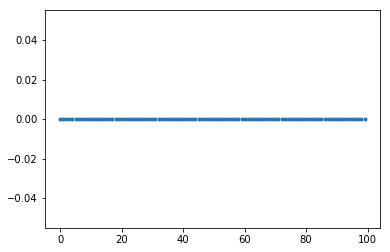

In [49]:
plt.close()
plt.plot(range(len(y_pred)), y_pred, '.')
plt.show()

In [6]:
dataset = np.loadtxt("pima-indians-diabetes.data.txt", delimiter=",")

In [85]:
dataset.shape

(768, 9)

In [7]:
X = dataset[:,0:8]
Y = dataset[:,8]

In [21]:
Y[-8:]

array([ 0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.])

In [8]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

from keras.wrappers.scikit_learn import KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

In [9]:
batch_size = [10]
epochs = [10]
param_grid = dict(batch_size=batch_size, nb_epoch=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X, Y)

In [10]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.608073 using {'batch_size': 10, 'nb_epoch': 10}


## Ensemble

In [212]:
rf = pd.read_csv('result_rf.csv')
gbm = pd.read_csv('result_lightgbm.csv')
xgb = pd.read_csv('result_xgb.csv')
y_rf = rf['201610']
y_gbm = gbm['201610']
y_xgb = xgb['201610']

In [214]:
y_ensemble = (y_rf+y_gbm)/2
sub = pd.read_csv('sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    sub[c] = y_ensemble

sub.to_csv('result_ensemble.csv', index=False, float_format='%.8f')